In [1]:
# Load necessary libraries and tools...

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import math
import psycopg2 as psy
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import pandas.io.sql as psql
%matplotlib inline


In [2]:
# Loading data from csv files...

In [3]:
cohort_1_w1w2 = pd.read_csv('/Users/cguy/kelstuff/ga_summer_2016/cohort_1_w1w2.csv')
cohort_1_w1w2.head()

/Users/cguy/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5,9,10,11,12,16,20,23,26,29,30,31,32,33,36,38,39,40,41,43,44,45,46,51,52,53,56,59,60,62,64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,AcSuppSv,AgeMP,AmIAKN,Asian,Baseline,BlkAfrAm,BudgetSv,CareerSv,CurrFTE,...,Sex,SpecEdSv,St,StFCID,StFIPS,SubAbuse,TribeSv,Wave,Weight,White
0,0,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450290395006,2.0,Yes,0.0,Wave 1: Age 17 Baseline Survey,1.26,1.0
1,4,0.0,17.0,1.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450448396586,2.0,No,1.0,Wave 1: Age 17 Baseline Survey,1.36,0.0
2,10,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,0.0,AK,AK450540097503,2.0,No,0.0,Wave 1: Age 17 Baseline Survey,1.26,1.0
3,14,0.0,17.0,0.0,0.0,Yes,0.0,0.0,0.0,No,...,1.0,0.0,AK,AK450652098623,2.0,No,0.0,Wave 1: Age 17 Baseline Survey,3.31,1.0
4,17,0.0,17.0,1.0,0.0,Yes,0.0,0.0,0.0,No,...,2.0,1.0,AK,AK451448406587,2.0,No,1.0,Wave 1: Age 17 Baseline Survey,1.36,0.0


In [4]:
cohort_1_w1w2.columns

Index([u'Unnamed: 0', u'AcSuppSv', u'AgeMP', u'AmIAKN', u'Asian', u'Baseline',
       u'BlkAfrAm', u'BudgetSv', u'CareerSv', u'CurrFTE', u'CurrPTE',
       u'CurrenRoll', u'DOB', u'DelinqntSv', u'EdLevlSv', u'EducFinaSv',
       u'Elig19', u'EmplyTrSv', u'FCStatSv', u'FY', u'FY11Cohort',
       u'FamSuppSv', u'HawaiiPI', u'HighEdCert', u'HisOrgin', u'HlthEdSv',
       u'Homeless', u'HousEdSv', u'ILNAsv', u'InSample', u'Incarc',
       u'Medicaid', u'MedicalIn', u'MentlHlthIn', u'MentorSv', u'Num_services',
       u'OthrFinAs', u'OthrFinaSv', u'OthrHlthIn', u'OutcmDte', u'OutcmFCS',
       u'OutcmRpt', u'PSEdSuppSv', u'PrescripIn', u'PubFinAs', u'PubFoodAs',
       u'PubHousAs', u'Race', u'RaceDcln', u'RaceEthn', u'RaceUnkn',
       u'RepDate_outcomes', u'RepDate_services', u'Responded', u'RmBrdFASv',
       u'SILsv', u'SampleState', u'Sex', u'SpecEdSv', u'St', u'StFCID',
       u'StFIPS', u'SubAbuse', u'TribeSv', u'Wave', u'Weight', u'White'],
      dtype='object')

# 1) Preprocess data and separate target variables from feature variables and demographics

In [5]:
# Seperate dataframe into feature vars and target vars

targets = cohort_1_w1w2[['PubFoodAs','PubHousAs','OthrFinAs','HighEdCert','CurrFTE','CurrPTE', \
                     'PubFinAs','CurrenRoll','PrescripIn','Homeless','SubAbuse','Incarc','Medicaid','OthrHlthIn','MedicalIn','MentlHlthIn', 'Wave']]


features = cohort_1_w1w2[['ILNAsv','AcSuppSv','PSEdSuppSv','CareerSv','EmplyTrSv','BudgetSv','HousEdSv','HlthEdSv',\
                     'FamSuppSv','MentorSv','SILsv','RmBrdFASv','EducFinaSv','OthrFinaSv','Wave']]

demographics = cohort_1_w1w2[['St','DelinqntSv','Sex','Race','TribeSv','EdLevlSv','SpecEdSv','RaceEthn','AgeMP','Wave']]
demographics_W1 = demographics[demographics.Wave == "Wave 1: Age 17 Baseline Survey"]
demographics_W2 = demographics[demographics.Wave == "Wave 2: Age 19 Followup"]

In [6]:
# # Create column for number of services received

services_count = features.T
services_count = services_count.drop('Wave')


features['Num_services'] = (services_count == 1).sum()
features.head(10)

/Users/cguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,Wave,Num_services
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wave 1: Age 17 Baseline Survey,2
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wave 1: Age 17 Baseline Survey,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Wave 1: Age 17 Baseline Survey,3
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Wave 1: Age 17 Baseline Survey,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wave 1: Age 17 Baseline Survey,2
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wave 1: Age 17 Baseline Survey,1
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,Wave 1: Age 17 Baseline Survey,4
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wave 1: Age 17 Baseline Survey,2
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wave 1: Age 17 Baseline Survey,1
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Wave 1: Age 17 Baseline Survey,2


In [7]:
# Let's focus on just W2 targets and features

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

features_2 = features.copy()

features_w2 = features_2[features_2.Wave == "Wave 2: Age 19 Followup"]
features_w2 = features_w2.drop('Wave', axis = 1)

features_w2.head()

,ILNAsv,AcSuppSv,PSEdSuppSv,CareerSv,EmplyTrSv,BudgetSv,HousEdSv,HlthEdSv,FamSuppSv,MentorSv,SILsv,RmBrdFASv,EducFinaSv,OthrFinaSv,Num_services
7328,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
7329,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7330,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,3
7331,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
7332,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

demographics_W2_ = demographics_W2.drop('Wave', axis = 1)


demo_w2 = demographics_W2_.copy()

for column in demo_w2:
    demo_w2[column] = le.fit_transform(demo_w2[column])
demo_w2.head()

,St,DelinqntSv,Sex,Race,TribeSv,EdLevlSv,SpecEdSv,RaceEthn,AgeMP
7328,0,0,1,0,0,6,0,0,1
7329,0,0,1,2,1,6,0,2,1
7330,0,0,1,0,0,6,0,0,1
7331,0,0,0,0,0,6,0,0,1
7332,0,0,1,2,1,6,1,2,1


In [9]:
new_features = pd.concat([features_w2, demo_w2], axis=1, join='inner')


In [13]:
new_features = new_features[['St','Num_services','EdLevlSv','HousEdSv','AcSuppSv','BudgetSv','CareerSv']]

In [14]:
new_features.head()

,St,Num_services,EdLevlSv,HousEdSv,AcSuppSv,BudgetSv,CareerSv
7328,0,2,6,1.0,0.0,0.0,0.0
7329,0,1,6,0.0,0.0,0.0,0.0
7330,0,3,6,0.0,0.0,0.0,0.0
7331,0,1,6,0.0,0.0,0.0,0.0
7332,0,2,6,0.0,0.0,0.0,0.0


# 2) PCA

In [15]:
# y-correlations

x_corr = np.corrcoef(new_features.values.T)
new_features.corr()

,St,Num_services,EdLevlSv,HousEdSv,AcSuppSv,BudgetSv,CareerSv
St,1.000000,-0.122563,0.101195,0.194507,0.193723,0.197298,0.195765
Num_services,-0.122563,1.000000,-0.077578,-0.230791,-0.234288,-0.231174,-0.230502
EdLevlSv,0.101195,-0.077578,1.000000,0.567649,0.566614,0.566649,0.567674
HousEdSv,0.194507,-0.230791,0.567649,1.000000,0.999200,0.999461,0.999344
AcSuppSv,0.193723,-0.234288,0.566614,0.999200,1.000000,0.999177,0.999233
BudgetSv,0.197298,-0.231174,0.566649,0.999461,0.999177,1.000000,0.999379
CareerSv,0.195765,-0.230502,0.567674,0.999344,0.999233,0.999379,1.000000


In [16]:
# Obtaining eigenvalues and eigenvectors for PCA

eig_vals, eig_vecs = np.linalg.eig(x_corr)
print eig_vals
print eig_vecs


[  4.49073216e+00   1.02364670e+00   8.80864039e-01   6.02673829e-01
   8.92605268e-04   5.28835961e-04   6.61829537e-04]
[[  1.18212068e-01  -6.95477054e-01  -7.07830000e-01  -3.61296888e-02
    2.20461665e-03  -1.83775245e-03  -8.20850156e-04]
 [ -1.34981478e-01   6.74842021e-01  -6.96043281e-01   2.04647768e-01
    3.14435856e-03   3.93498267e-04  -1.11665646e-03]
 [  3.09829770e-01   2.19494855e-01  -1.17081346e-01  -9.17669722e-01
    4.00660803e-04   1.14912616e-03  -5.30700016e-04]
 [  4.66851611e-01   5.76483045e-02   1.38025331e-02   1.68952273e-01
   -3.53967032e-01  -6.44499316e-01  -4.57513758e-01]
 [  4.66823650e-01   5.56301328e-02   1.73303386e-02   1.69276799e-01
    8.39525698e-01   6.94707881e-02  -2.00988571e-01]
 [  4.66868861e-01   5.52849083e-02   1.19934533e-02   1.70182414e-01
   -4.04071742e-01   7.42703149e-01  -1.87054024e-01]
 [  4.66872725e-01   5.69865073e-02   1.25581693e-02   1.68922052e-01
   -8.13330356e-02  -1.67873825e-01   8.45750167e-01]]


In [17]:
# Obtaining cumulative explained variance

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print cum_var_exp

[  64.15331656   78.77684089   91.36061287   99.97023899   99.98299049
   99.9924452   100.        ]


In [18]:
# From output of cell above, we can see 
# that the first two principal components explain 92.6% of the variance in the target variables

In [19]:
# Obtaining eigenpairs...

value_vector_pairs = [[eig_vals[i], eig_vecs[:,i]] for i in range(len(eig_vals))]
value_vector_pairs.sort(reverse=True)

In [20]:
# Transforming eigen data to obtain 2d PCA projection matrix in order to plot principal components

weight_2d_projection = np.hstack((value_vector_pairs[0][1].reshape(eig_vecs.shape[1],1),
                                  value_vector_pairs[1][1].reshape(eig_vecs.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection

Weight data 2d PCA projection matrix:
[[ 0.11821207 -0.69547705]
 [-0.13498148  0.67484202]
 [ 0.30982977  0.21949486]
 [ 0.46685161  0.0576483 ]
 [ 0.46682365  0.05563013]
 [ 0.46686886  0.05528491]
 [ 0.46687273  0.05698651]]


In [21]:
Z = new_features.dot(weight_2d_projection)


### PC1 vs PC2

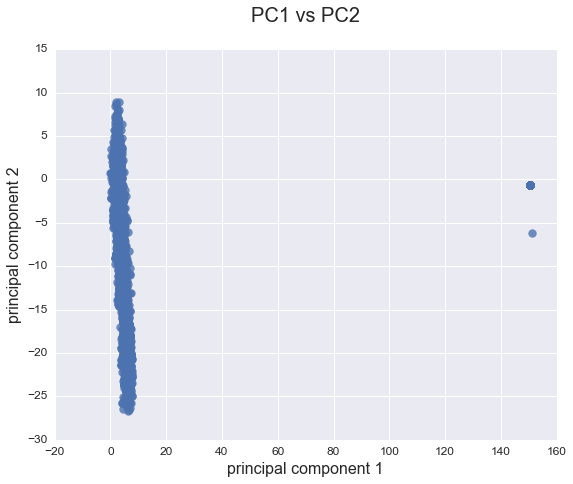

In [22]:
fig = plt.figure(figsize=(9,7))

ax = fig.gca()
ax = sns.regplot(Z.iloc[:,0], Z.iloc[:,1],
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=16)
ax.set_ylabel('principal component 2', fontsize=16)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('PC1 vs PC2\n', fontsize=20)

plt.show()

In [23]:
# Will now transform data so that PC1 and PC2 can be plotted with individual target variables...
# Need to do this in order to see which variables are more likely part of the principal components...

new_features_2 = new_features

NFeat_pcs = new_features_2.copy

NFeat_pcs = (new_features_2 - new_features_2.mean()) / new_features_2.std()

NFeat_pcs['PC1'] = Z.iloc[:,0]
NFeat_pcs['PC2'] = Z.iloc[:,1]

In [24]:
NFeat_pcs = pd.melt(NFeat_pcs, id_vars=['PC1','PC2'])


In [25]:
NFeat_pcs.head()

,PC1,PC2,variable,value
0,2.055867,2.724301,St,-1.396589
1,1.723997,1.991811,St,-1.396589
2,1.454034,3.341495,St,-1.396589
3,1.723997,1.991811,St,-1.396589
4,1.589016,2.666653,St,-1.396589


### PC1 vs New Features

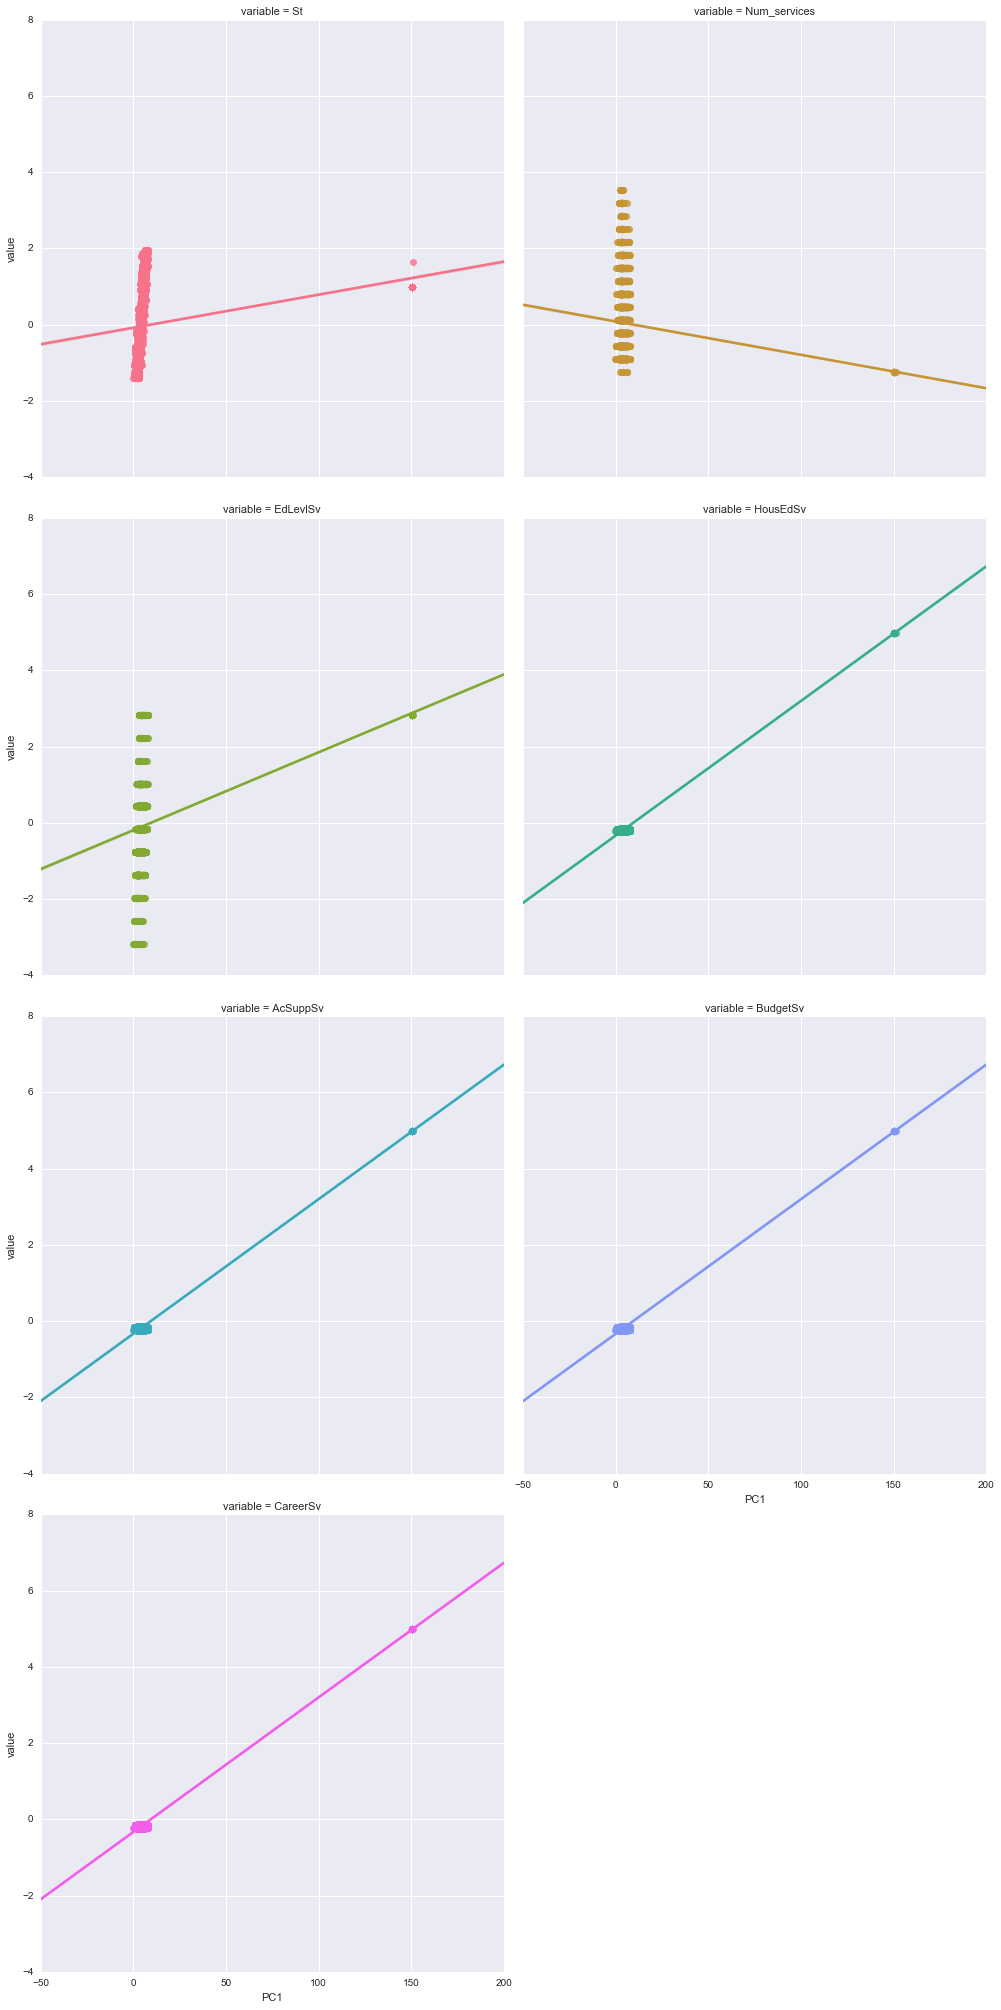

In [26]:
pc1 = sns.lmplot(x="PC1", y="value", col="variable", hue="variable", 
                 data=NFeat_pcs, col_wrap=2, size=7, scatter_kws={'s':50})

### PC2 vs New Features

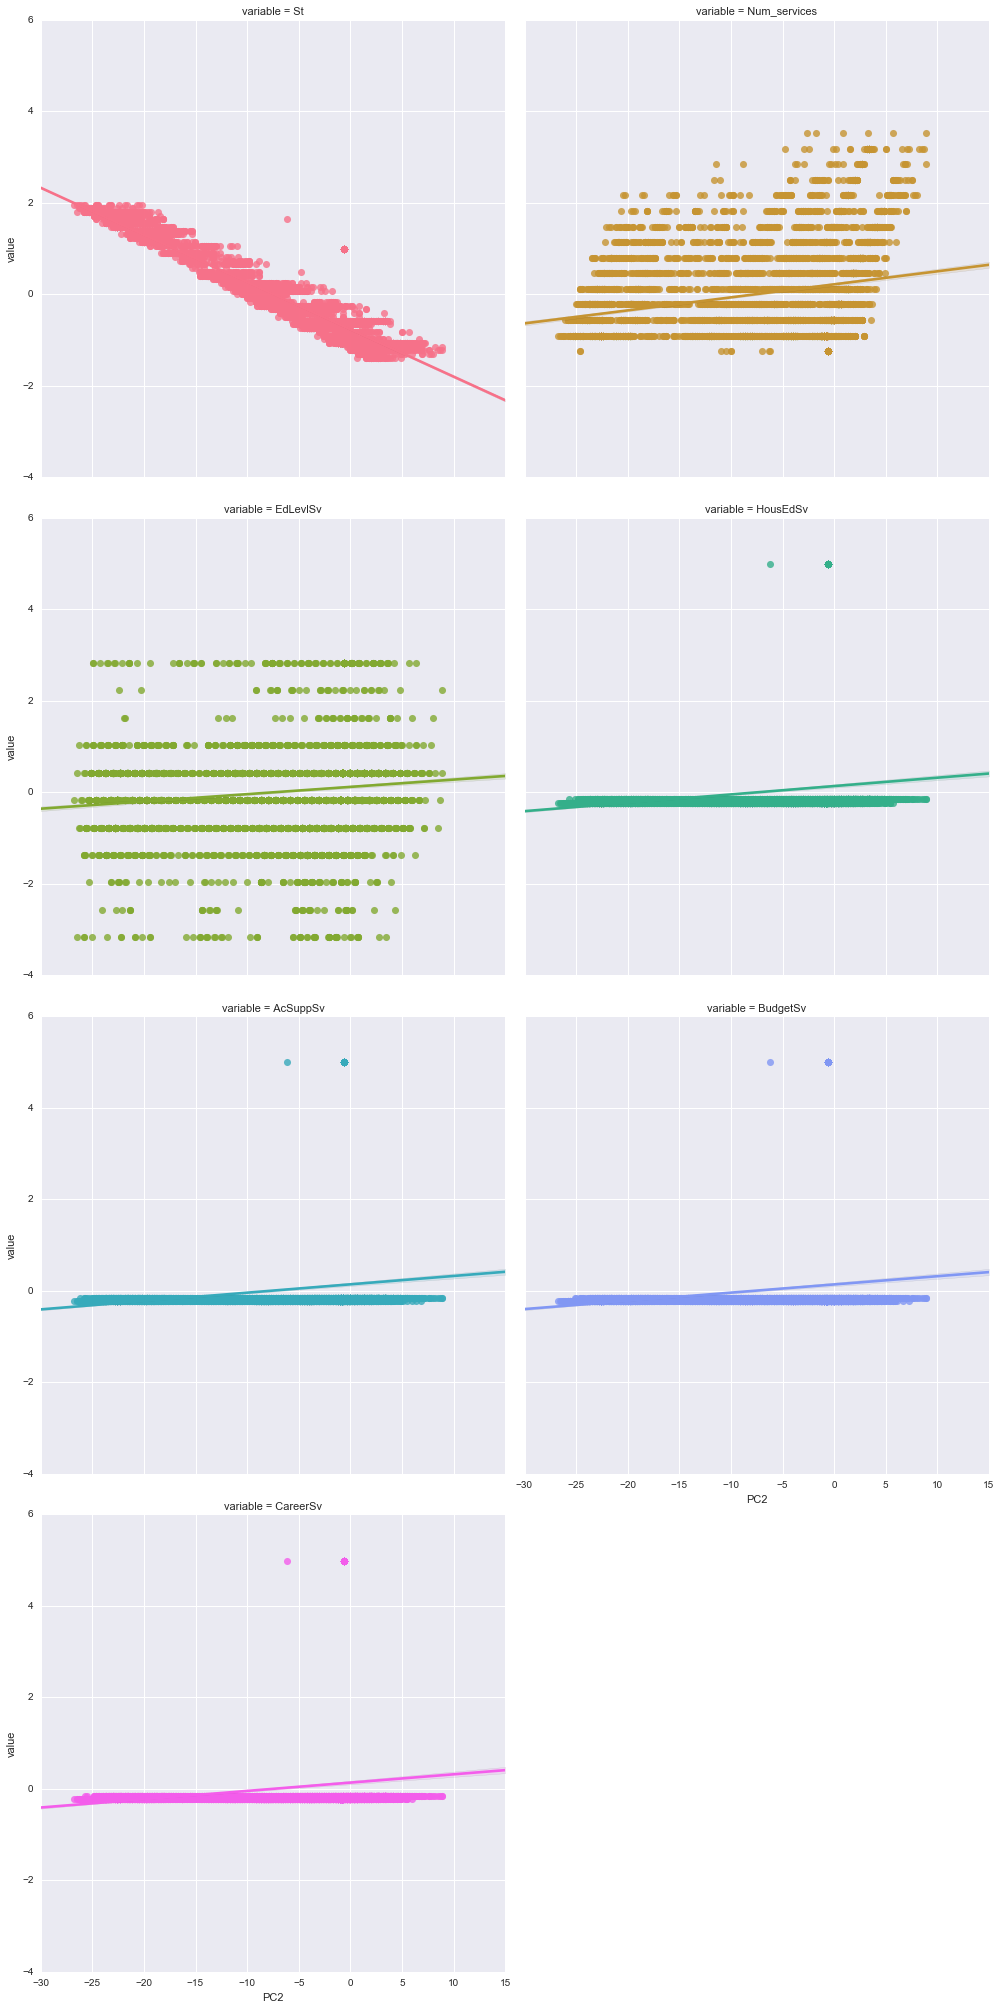

In [27]:
pc2 = sns.lmplot(x="PC2", y="value", col="variable", hue="variable", 
                 data=NFeat_pcs, col_wrap=2, size=7, scatter_kws={'s':50})


In [28]:
# From the PCAs so far, can see that HighEdCert should be the target variable for this project

In [32]:
from matplotlib.mlab import PCA
#construct your numpy array of data
myData = np.array(new_features) 
results = PCA(myData) 

#this will return an array of variance percentages for each component
results.fracs

#this will return a 2d array of the data projected into PCA space
results.Y 

array([[ -3.48250108e-01,   6.34892755e-01,  -1.32194200e+00, ...,
          3.68867593e-02,   2.96508810e-02,  -4.06403487e-02],
       [ -3.33843200e-01,   4.01004820e-01,  -1.55821980e+00, ...,
          1.40031343e-02,  -1.69257247e-03,   2.84295775e-03],
       [ -4.25846713e-01,   8.60977828e-01,  -1.08379599e+00, ...,
          1.18599363e-02,  -9.31458291e-04,   3.11116657e-03],
       ..., 
       [  4.83321332e-02,  -1.69812062e+00,   1.05213706e+00, ...,
         -5.13835054e-02,   1.50684669e-02,   1.52269878e-03],
       [ -4.43970098e-01,  -1.03359950e+00,   1.85881423e+00, ...,
         -2.57274621e-02,  -1.03458268e-02,  -5.43023598e-02],
       [ -1.69068841e-01,  -1.83348470e+00,   9.83119029e-01, ...,
          5.77665271e-03,   1.12324820e-03,  -3.87635806e-03]])

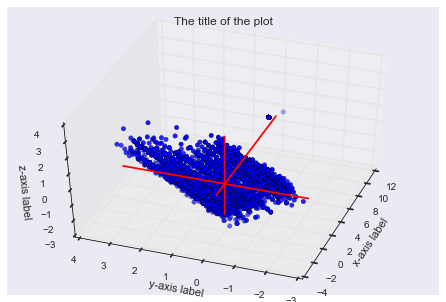

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

x = []
y = []
z = []
for item in results.Y:
 x.append(item[0])
 y.append(item[1])
 z.append(item[2])

plt.close('all') # close all latent plotting windows
fig1 = plt.figure() # Make a plotting figure
ax = Axes3D(fig1) # use the plotting figure to create a Axis3D object.
pltData = [x,y,z] 
ax.scatter(pltData[0], pltData[1], pltData[2], 'bo') # make a scatter plot of blue dots from the data
 
# make simple, bare axis lines through space:
xAxisLine = ((min(pltData[0]), max(pltData[0])), (0, 0), (0,0)) # 2 points make the x-axis line at the data extrema along x-axis 
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r') # make a red line for the x-axis.
yAxisLine = ((0, 0), (min(pltData[1]), max(pltData[1])), (0,0)) # 2 points make the y-axis line at the data extrema along y-axis
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r') # make a red line for the y-axis.
zAxisLine = ((0, 0), (0,0), (min(pltData[2]), max(pltData[2]))) # 2 points make the z-axis line at the data extrema along z-axis
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r') # make a red line for the z-axis.
 
# label the axes 
ax.set_xlabel("x-axis label") 
ax.set_ylabel("y-axis label")
ax.set_zlabel("z-axis label")
ax.set_title("The title of the plot")

ax.azim = 200
ax.elev = 45


plt.show() # show the plot



# 3) Feature Importance over BEST Demographics and Features

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [38]:
targets_w2 = pd.read_csv('/Users/cguy/kelstuff/ga_summer_2016/targets_w2.csv')
targets_w2.head()

,Unnamed: 0,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn
0,7328,4,2,2,7,2,2,2,2,4,3,2,2,4,4,4,4
1,7329,2,2,2,5,2,2,2,2,4,2,2,2,3,4,4,4
2,7330,4,2,2,5,2,2,2,3,4,2,3,3,4,4,4,4
3,7331,4,2,2,5,2,3,2,2,4,3,2,2,4,4,4,4
4,7332,4,2,2,5,3,2,2,2,4,3,2,2,4,5,2,4


In [39]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

targets_w2_ = targets[targets.Wave == "Wave 2: Age 19 Followup"]
targets_w2_ = targets_w2_.drop('Wave', axis = 1)


targets_w2 = targets_w2_.copy()

for column in targets_w2:
    targets_w2[column] = le.fit_transform(targets_w2[column])
targets_w2.head()

/Users/cguy/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn
7328,4,2,2,7,2,2,2,2,4,3,2,2,4,4,4,4
7329,2,2,2,5,2,2,2,2,4,2,2,2,3,4,4,4
7330,4,2,2,5,2,2,2,3,4,2,3,3,4,4,4,4
7331,4,2,2,5,2,3,2,2,4,3,2,2,4,4,4,4
7332,4,2,2,5,3,2,2,2,4,3,2,2,4,5,2,4


In [40]:
targets_labels = targets[targets.Wave == "Wave 2: Age 19 Followup"]


In [41]:
# y = 0 v 1, 
    # where 1 = Vocational certificate (8), Vocational license (9), Associate's Degree (6), 
            #   Higher degree (1), Bachelor's Degree (2)
    # or 1 = when CurrenRoll == 3

def determine_Success(row):
    column_1 = 'HighEdCert'
    column_2 = 'CurrenRoll'
    if row[column_1] == 1:
        val = 1
    elif row[column_1] ==  2:
        val = 1
    elif row[column_1] ==  6:
        val = 1
    elif row[column_1] ==  9:
        val = 1
    elif row[column_1] ==  8:
        val = 1
    elif row[column_2] == 3:
        val = 1
    else:
        val = 0
    return val
    
targets_w2_final = targets_w2.copy()

targets_w2_final['Success'] = targets_w2_final.apply(determine_Success, axis=1)
targets_w2_final.head(10)



,PubFoodAs,PubHousAs,OthrFinAs,HighEdCert,CurrFTE,CurrPTE,PubFinAs,CurrenRoll,PrescripIn,Homeless,SubAbuse,Incarc,Medicaid,OthrHlthIn,MedicalIn,MentlHlthIn,Success
7328,4,2,2,7,2,2,2,2,4,3,2,2,4,4,4,4,0
7329,2,2,2,5,2,2,2,2,4,2,2,2,3,4,4,4,0
7330,4,2,2,5,2,2,2,3,4,2,3,3,4,4,4,4,1
7331,4,2,2,5,2,3,2,2,4,3,2,2,4,4,4,4,0
7332,4,2,2,5,3,2,2,2,4,3,2,2,4,5,2,4,0
7333,3,3,2,7,2,2,3,3,4,2,2,2,4,4,4,4,1
7334,3,3,2,7,2,2,3,3,5,2,2,2,4,5,5,5,1
7335,2,2,2,5,2,2,2,2,5,2,2,2,4,5,5,3,0
7336,4,2,2,7,3,2,2,2,4,3,2,3,4,4,4,4,0
7337,2,1,3,7,2,2,1,3,4,3,2,3,4,4,4,4,1


In [42]:
targets_w2_final['Success'].value_counts()

0    4830
1    2498
Name: Success, dtype: int64

In [43]:
new_features.head()

,St,Num_services,EdLevlSv,HousEdSv,AcSuppSv,BudgetSv,CareerSv
7328,0,2,6,1.0,0.0,0.0,0.0
7329,0,1,6,0.0,0.0,0.0,0.0
7330,0,3,6,0.0,0.0,0.0,0.0
7331,0,1,6,0.0,0.0,0.0,0.0
7332,0,2,6,0.0,0.0,0.0,0.0


In [44]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = targets_w2_final['Success']
X = new_features

# dem2 = demographics_W2.copy()

# for column in dem2:
#     dem2[column] = le.fit_transform(dem2[column])
# dem2.head()


# X2 = dem2

In [45]:
# X2.head()

In [46]:
X.head()

,St,Num_services,EdLevlSv,HousEdSv,AcSuppSv,BudgetSv,CareerSv
7328,0,2,6,1.0,0.0,0.0,0.0
7329,0,1,6,0.0,0.0,0.0,0.0
7330,0,3,6,0.0,0.0,0.0,0.0
7331,0,1,6,0.0,0.0,0.0,0.0
7332,0,2,6,0.0,0.0,0.0,0.0


In [47]:
y

7328     0
7329     0
7330     1
7331     0
7332     0
7333     1
7334     1
7335     0
7336     0
7337     1
7338     1
7339     0
7340     0
7341     1
7342     1
7343     0
7344     0
7345     0
7346     1
7347     0
7348     0
7349     1
7350     0
7351     0
7352     0
7353     1
7354     0
7355     0
7356     0
7357     1
        ..
14626    0
14627    0
14628    0
14629    0
14630    0
14631    0
14632    0
14633    0
14634    1
14635    0
14636    1
14637    1
14638    0
14639    0
14640    0
14641    0
14642    0
14643    0
14644    1
14645    0
14646    0
14647    0
14648    0
14649    0
14650    0
14651    0
14652    0
14653    0
14654    0
14655    1
Name: Success, dtype: int64

In [48]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2)

dt.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [49]:
pd.Series(y).value_counts()


0    4830
1    2498
Name: Success, dtype: int64

In [50]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
St,0.952044
EdLevlSv,0.047956
Num_services,0.000000
HousEdSv,0.000000
AcSuppSv,0.000000


In [51]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(-1, 7)

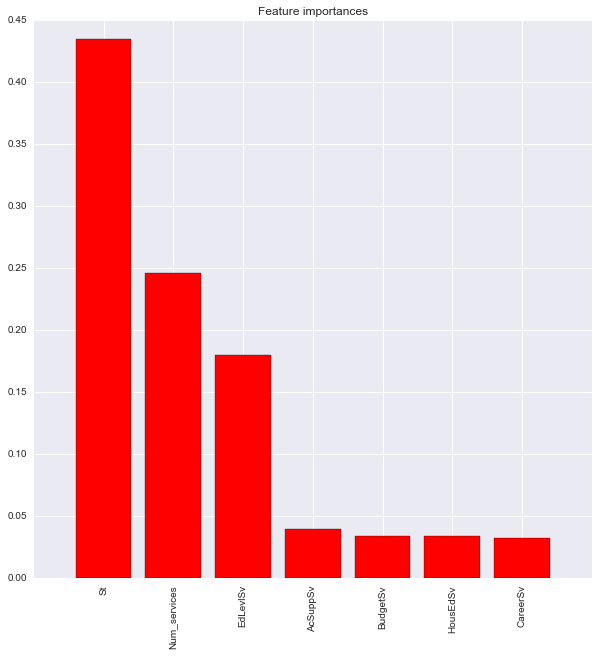

In [52]:
all(rf.feature_importances_ == np.mean([dt.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 
std = np.std([dt.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])

,dt_importance,rf_importance,et_importance
St,0.257773,0.435035,0.489035
Num_services,0.274701,0.246370,0.196627
EdLevlSv,0.171801,0.179621,0.222562
AcSuppSv,0.090100,0.039793,0.023093
BudgetSv,0.066847,0.033647,0.024129
HousEdSv,0.065863,0.033552,0.019708
CareerSv,0.072914,0.031983,0.024846


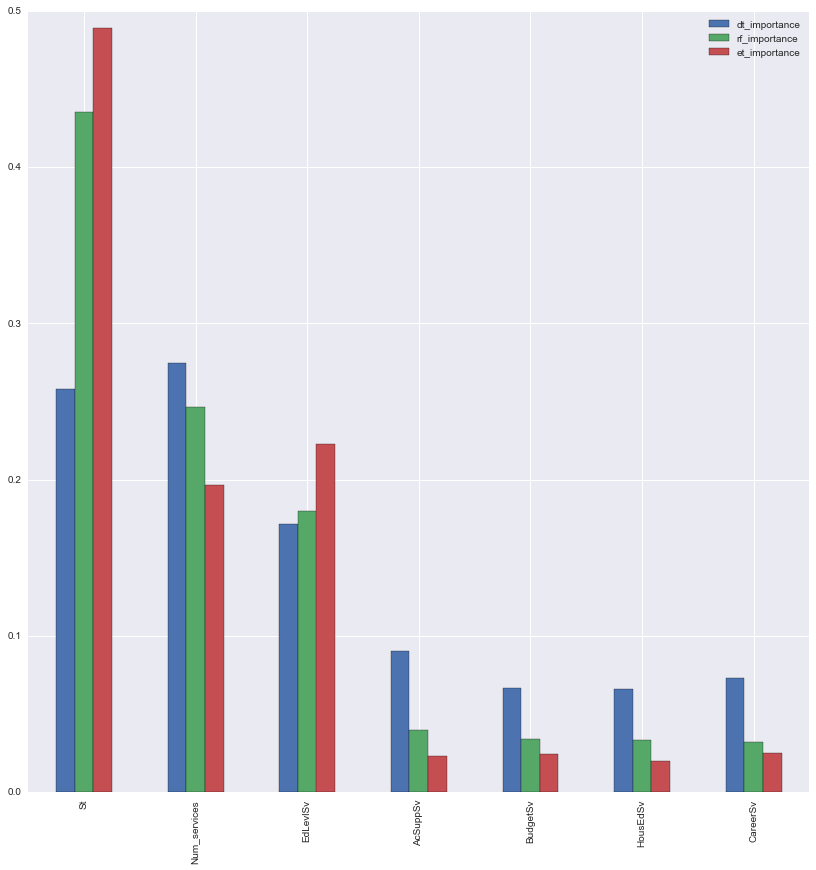

In [53]:
dt = DecisionTreeClassifier()
dt.fit(X, y)

et.fit(X, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar', figsize=(14,14))
importances.head(10)

In [54]:
importances_dt = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('dt_importance',
                                                                   ascending=False)

                           
importances_dt.head(10)

,dt_importance,rf_importance,et_importance
Num_services,0.274701,0.246370,0.196627
St,0.257773,0.435035,0.489035
EdLevlSv,0.171801,0.179621,0.222562
AcSuppSv,0.090100,0.039793,0.023093
CareerSv,0.072914,0.031983,0.024846
BudgetSv,0.066847,0.033647,0.024129
HousEdSv,0.065863,0.033552,0.019708


In [55]:
importances_et = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('et_importance',
                                                                   ascending=False)

                           
importances_et.head(10)

,dt_importance,rf_importance,et_importance
St,0.257773,0.435035,0.489035
EdLevlSv,0.171801,0.179621,0.222562
Num_services,0.274701,0.246370,0.196627
CareerSv,0.072914,0.031983,0.024846
BudgetSv,0.066847,0.033647,0.024129
AcSuppSv,0.090100,0.039793,0.023093
HousEdSv,0.065863,0.033552,0.019708


# The following not applicable.....in current state of X.......
### Now with X2

In [67]:
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2)

dt.fit(X2, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [68]:
pd.Series(y).value_counts()


0    4830
1    2498
Name: Success, dtype: int64

In [69]:
feature_importances = pd.DataFrame(dt.feature_importances_,
                                   index = X2.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
St,0.562136
DelinqntSv,0.336571
TribeSv,0.050387
Race,0.041551
RaceEthn,0.009354


In [70]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X2, y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

(-1, 10)

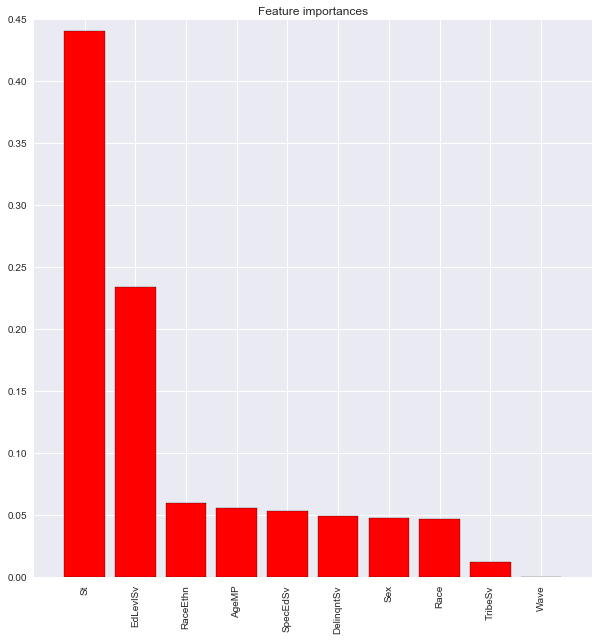

In [71]:
all(rf.feature_importances_ == np.mean([dt.feature_importances_ for tree in rf.estimators_], axis=0))

importances = rf.feature_importances_
# calculate the standard deviation of feature importances by looping over the trees in the random forest
# 
std = np.std([dt.feature_importances_ for tree in rf.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
feature_names = X2.columns

# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("Feature importances")
plt.bar(range(X2.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X2.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X2.shape[1]])

,dt_importance,rf_importance,et_importance
St,0.324949,0.440175,0.507566
EdLevlSv,0.191223,0.234422,0.235136
RaceEthn,0.073021,0.059622,0.045108
AgeMP,0.127478,0.055949,0.029772
SpecEdSv,0.081283,0.053707,0.043633
DelinqntSv,0.049586,0.049395,0.064699
Sex,0.062664,0.047570,0.018845
Race,0.061703,0.046703,0.042521
TribeSv,0.028094,0.012456,0.012719
Wave,0.000000,0.000000,0.000000


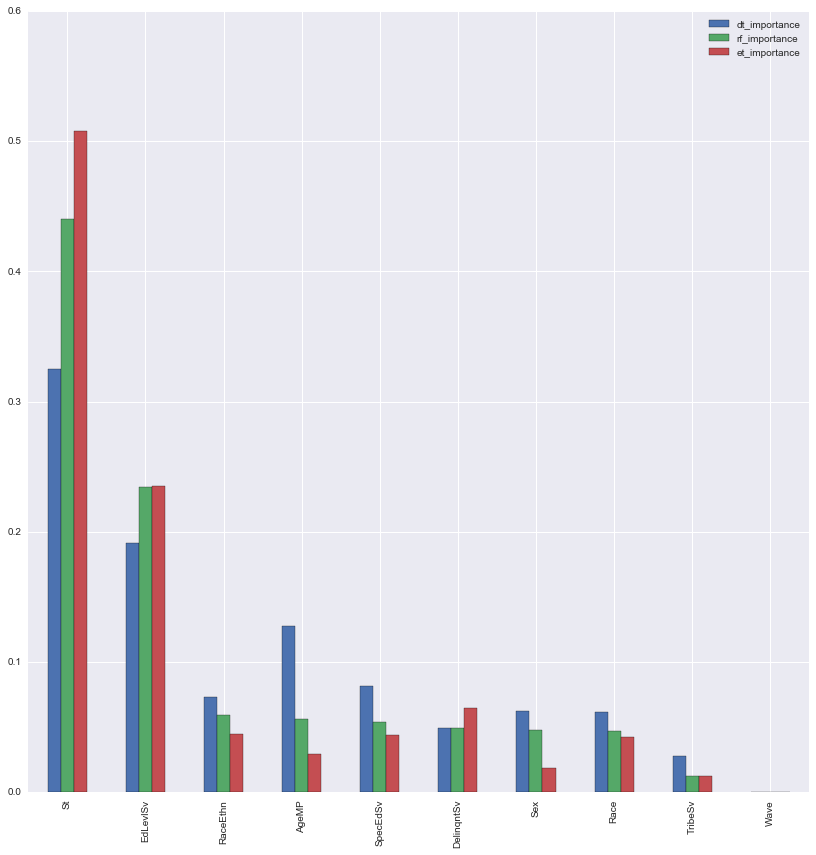

In [72]:
dt = DecisionTreeClassifier()
dt.fit(X2, y)

et.fit(X2, y)

importances = pd.DataFrame(zip(dt.feature_importances_,
                               rf.feature_importances_,
                               et.feature_importances_),
                           index=X2.columns,
                           columns=['dt_importance',
                                    'rf_importance',
                                    'et_importance']).sort_values('rf_importance',
                                                                   ascending=False)

                           
importances.plot(kind='bar', figsize=(14,14))
importances.head(10)